In [20]:
from PYME.localization.FitFactories import DumbellFitR as dbfr
import numpy as np
from math import exp
import matplotlib.pyplot as plt
from scipy.optimize import fmin
from PYME.IO.image import ImageStack
from scipy import ndimage
from scipy.special import erf as erf

In [47]:
# see pg 39, http://robots.stanford.edu/cs223b04/SteerableFiltersfreeman91design.pdf
def g2a(x, y, sig):
    return (1 / (2 * np.pi * sig**4)) * (x**2 - sig**2) * np.exp(- (x**2 + y**2) / (2 * sig**2))
def g2b(x, y, sig):
    return (1 / (2 * np.pi * sig**4)) * x*y*np.exp(- (x**2 + y**2) / (2 * sig**2))
def g2c(x, y, sig):
    return (1 / (2 * np.pi * sig**4)) * (y**2 - sig**2) * np.exp(- (x**2 + y**2) / (2 * sig**2))
# separatable basis set and interpolation functions for fit to hilbert transform of second derivative of gaussian
def h2a(x, y, sig):
    return (1 / (3 * np.sqrt(2) * np.pi**(3/2) * sig**5)) * np.exp(- (x**2 + y**2) / (2 * sig**2)) * (x**3 - 6 * x * sig**2)
def h2b(x, y, sig):
    return (1 / (3 * np.sqrt(2) * np.pi**(3/2) * sig**5)) * np.exp(- (x**2 + y**2) / (2 * sig**2)) * (x**2 - 2 * sig**2) * y
def h2c(x, y, sig):
    return (1 / (3 * np.sqrt(2) * np.pi**(3/2) * sig**5)) * np.exp(- (x**2 + y**2) / (2 * sig**2)) * (y**2 - 2 * sig**2) * x
def h2d(x, y, sig):
    return (1 / (3 * np.sqrt(2) * np.pi**(3/2) * sig**5)) * np.exp(- (x**2 + y**2) / (2 * sig**2)) * (y**3 - 6 * y * sig**2)


def computeStrengthMap(sigma, image, s, l):
    
    roiHalfSize = 10 # [pixels]

    xx = np.mgrid[(-roiHalfSize):(roiHalfSize + 1)]
    yy = np.mgrid[(-roiHalfSize):(roiHalfSize + 1)]


    X, Y = xx[:, None], yy[None, :]

    f1 = g2a(Y, X, sigma)
    f2 = g2b(Y, X, sigma)
    f3 = g2c(Y, X, sigma)

    g2a_xy = ndimage.convolve(image, f1)
    g2b_xy = ndimage.convolve(image, f2)
    g2c_xy = ndimage.convolve(image, f3)
    
    fha = h2a(Y, X, sigma)
    fhb = h2b(Y, X, sigma)
    fhc = h2c(Y, X, sigma)
    fhd = h2d(Y, X, sigma)

    h2a_xy = ndimage.convolve(image, fha)
    h2b_xy = ndimage.convolve(image, fhb)
    h2c_xy = ndimage.convolve(image, fhc)
    h2d_xy = ndimage.convolve(image, fhd)

    c_2= 0.5 * (g2a_xy**2 - g2c_xy**2) \
                + 0.46875*(h2a_xy**2 - h2d_xy**2) \
                + 0.28125*(h2b_xy**2 - h2c_xy**2) \
                + 0.1875 * (h2a_xy*h2c_xy - h2b_xy * h2d_xy)
    c_3 = - g2a_xy*g2b_xy - g2b_xy * g2c_xy \
                - 0.9375 * (h2c_xy * h2d_xy + h2a_xy * h2b_xy) \
                - 1.6875 * h2b_xy * h2c_xy - 0.1875 * h2a_xy * h2d_xy
    
    A = 1
    S = lambda x : np.pi * np.sqrt(((1 / (s**2 + x**2)**6) * A**4 * s**8 * x**8 ) * ((exp((-(1+l)**2)/(4 * (s**2 + x**2)))) * ((1 - exp(l/(2 * (s**2 + x**2))) * (-1 + l) + l)**2) * (erf(1/(2 * np.sqrt(2) * np.sqrt(s**2 + x**2)))**2) - (exp((-1)/(4 * (s**2 + x**2)))) * ((erf((-1 + l)/(2 * np.sqrt(2) *np.sqrt(s**2 + x**2))) - erf((1 + l)/(2 * np.sqrt(2) *np.sqrt(s**2 + x**2))))**2))**2)
    normFactor = S(sigma)
    
    strengthMap = np.sqrt(c_2 ** 2 + c_3 ** 2)
    
    return strengthMap


def StrengthVsSigma(sigmas, image, s, l):
        
    strengths = np.asarray(np.zeros(sigmas.size), dtype=float)
    
    for i in list(range(0,sigmas.size)):
    
        strengthMap = computeStrengthMap(sigmas[i], image, s, l)
        strengths[i] = np.max(strengthMap)
     
    plt.figure()
    plt.plot(sigmas, strengths)
    print("optimal sigma = " + str(sigs[np.unravel_index(np.argmax(strengths), strengths.shape)[0]]))
    
    return strengths

def OptimalSigmabyFrame(PSFStack, sigmas, s, l):
    
    optSigmas = np.asarray(np.zeros(PSFStack.shape[2]), dtype=float)
    maxX = np.asarray(np.zeros(PSFStack.shape[2]), dtype=float)
    maxY = np.asarray(np.zeros(PSFStack.shape[2]), dtype=float)
    
    for j in list(range(0,PSFStack.shape[2])):
    
        strengths = np.asarray(np.zeros(sigmas.size), dtype=float)

        X = np.asarray(np.zeros(sigmas.size), dtype=float)
        Y = np.asarray(np.zeros(sigmas.size), dtype=float)
        
        for i in list(range(0,sigmas.size)):

            
            strengthMap = computeStrengthMap(sigmas[i], PSFStack[:,:,j],s, l)
            strengths[i] = np.max(strengthMap)
            X[i] = np.unravel_index(np.argmax(strengthMap), strengthMap.shape)[1]
            Y[i] = np.unravel_index(np.argmax(strengthMap), strengthMap.shape)[0]

        optSigmas[j] = sigs[np.unravel_index(np.argmax(strengths), strengths.shape)[0]]
        maxX[j] = X[np.unravel_index(np.argmax(strengths), strengths.shape)[0]]
        maxY[j] = Y[np.unravel_index(np.argmax(strengths), strengths.shape)[0]]
        
    plt.figure()
    plt.plot(list(range(0,PSFStack.shape[2])), optSigmas)
    plt.xlabel("Frame")
    plt.ylabel("Optimal Filter Sigma")
    
    return optSigmas, strengths, maxX, maxY
    

def StrengthVsZ(PSFStack, sigma, s, l, midSlice):
    
    
    strengths = np.asarray(np.zeros(PSFStack.shape[2]), dtype=float)
    dhAmplitudes = np.asarray(np.zeros(PSFStack.shape[2]), dtype=float)
    maxX = np.asarray(np.zeros(PSFStack.shape[2]), dtype=float)
    maxY = np.asarray(np.zeros(PSFStack.shape[2]), dtype=float)
    
    for i in list(range(0,PSFStack.shape[2])):
    
        strengthMap = computeStrengthMap(sigma, PSFStack[:,:,i], s, l)
        strengths[i] = np.max(strengthMap)
        dhAmplitudes[i] = np.max(PSFStack[:,:,i])
        maxX[i] = np.unravel_index(np.argmax(strengthMap), strengthMap.shape)[1]
        maxY[i] = np.unravel_index(np.argmax(strengthMap), strengthMap.shape)[0]
                                   
        
        
        
    plt.figure()
    plt.imshow(computeStrengthMap(sigma, PSFStack[:,:,midSlice], s, l), origin="lower")
                                   
    plt.figure()
    plt.imshow(PSFStack[:,:,midSlice], origin="lower")
    plt.scatter(maxX, maxY, color="red")
    
    plt.figure()
    plt.plot(list(range(0,PSFStack.shape[2])), dhAmplitudes)
    plt.xlabel("Frame")
    plt.ylabel("DH Amplitude")
    
    plt.figure()
    plt.plot(list(range(0,PSFStack.shape[2])), strengths)
    plt.xlabel("Frame")
    plt.ylabel("Max Strength")
    
    plt.figure()
    plt.plot(list(range(0,PSFStack.shape[2])), strengths/dhAmplitudes)
    plt.xlabel("Frame")
    plt.ylabel("Max Strength/DH Amplitude")
    return strengths, maxX, maxY

In [48]:
im = ImageStack(filename = "E:/Toxoplasma_Fixed_Cell_Imaging/20240630_MyoH_Single_Color/Z_Stack_2_step_avg_CROP.h5", haveGUI=False)
im.mdh['Camera.NoiseFactor'] = 1.4 # typical for EMCCD with gain > 10
im.mdh['Camera.ElectronsPerCount'] = 12.9  # e-/ADU
im.mdh['Camera.ADOffset'] = 110 # [ADU]
im.mdh['voxelsize.x'] = 0.1175 # [um]
im.mdh['voxelsize.y'] = 0.1175 # [um]

dh_stack=np.squeeze(im.data_xytc[:,:,:,0]) 


filename == E:\Toxoplasma_Fixed_Cell_Imaging\20240630_MyoH_Single_Color\Z_Stack_2_step_avg_CROP.h5
E:\Toxoplasma_Fixed_Cell_Imaging\analysis\20240630_MyoH_Single_Color\Z_Stack_2_step_avg_CROP.h5r


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002737F7BE3C8>


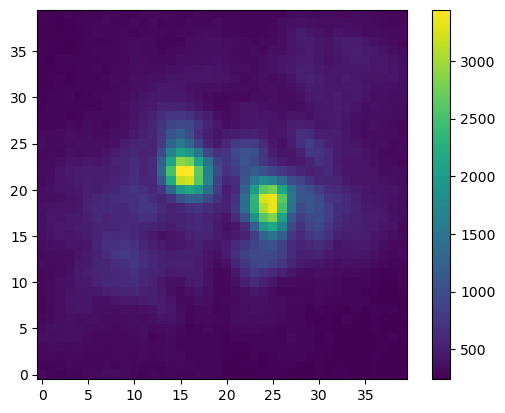

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002737E131288>


optimal sigma = 1.2


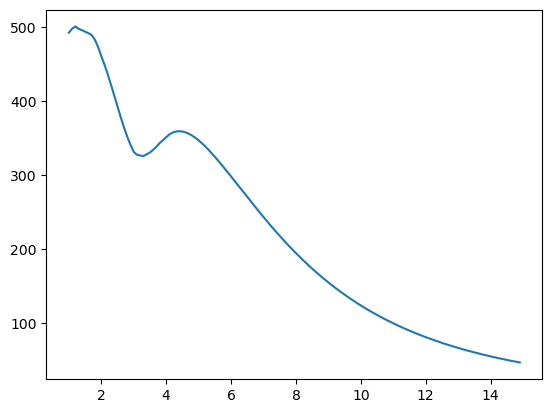

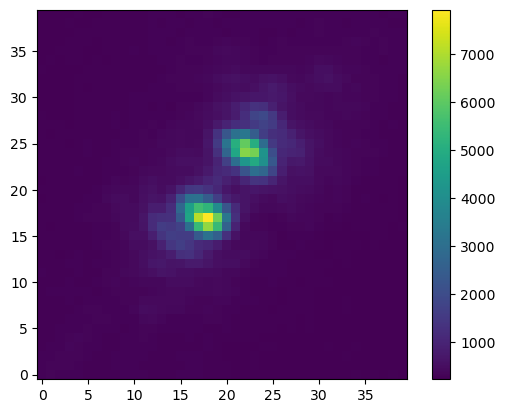

optimal sigma = 1.0


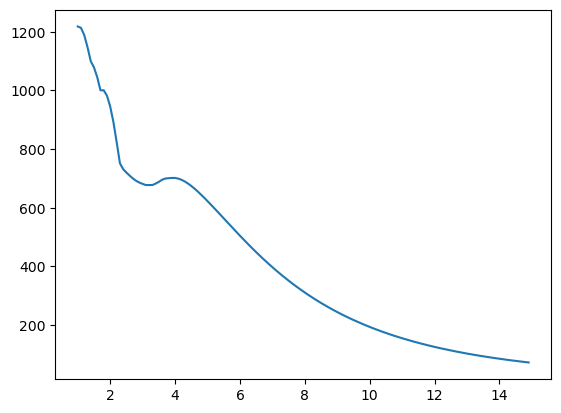

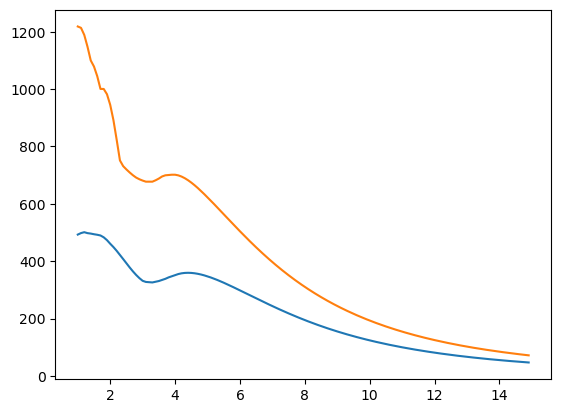

In [49]:
dh2 = dh_stack[:,:,2]
dh25 = dh_stack[:,:,25]

plt.figure()
plt.imshow(dh2, origin="lower")
plt.colorbar()
plt.show()

sigmaUB = 15
sigs = np.array(range(10,sigmaUB*10,1), dtype=float)/10

s = 190/120;
l = 1015/120;

s3 = StrengthVsSigma(sigs, dh2, s, l)

plt.figure()
plt.imshow(dh25, origin="lower")
plt.colorbar()
plt.show()

s25 = StrengthVsSigma(sigs, dh25, s, l)

plt.figure()
plt.plot(sigs, s3)
plt.plot(sigs, s25)


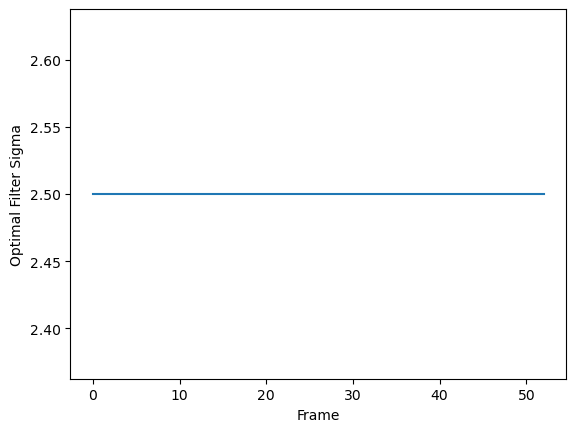

In [31]:
optimalSigs, maxStrengths, maxXforOptSigma, maxYforOptSigma = OptimalSigmabyFrame(dh_stack, sigs, 190/120.0, 1015/120.0)

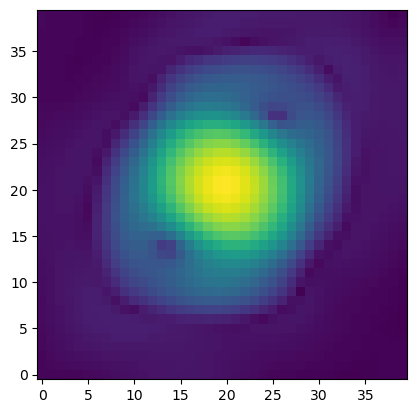

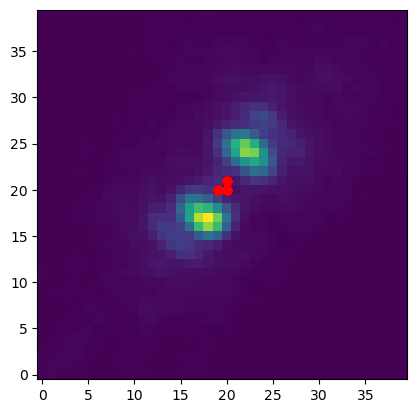

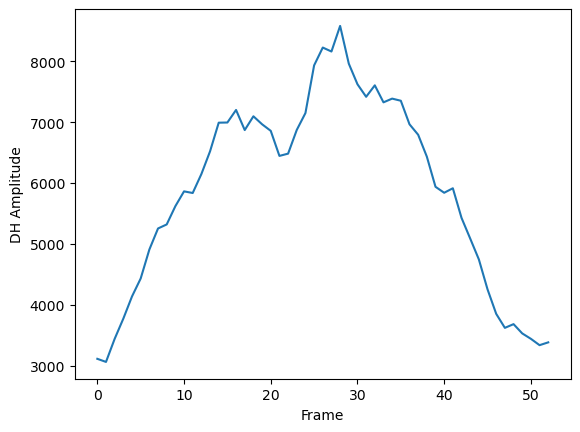

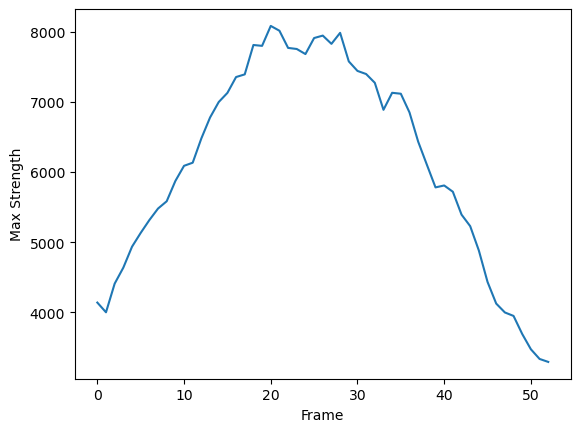

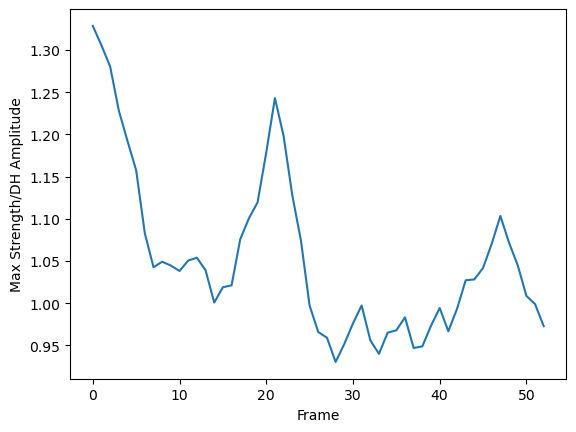

In [40]:
strengths, maxX, maxY = StrengthVsZ(dh_stack, sigma=5, s=190/120.0, l=1025/120.0, midSlice=25)

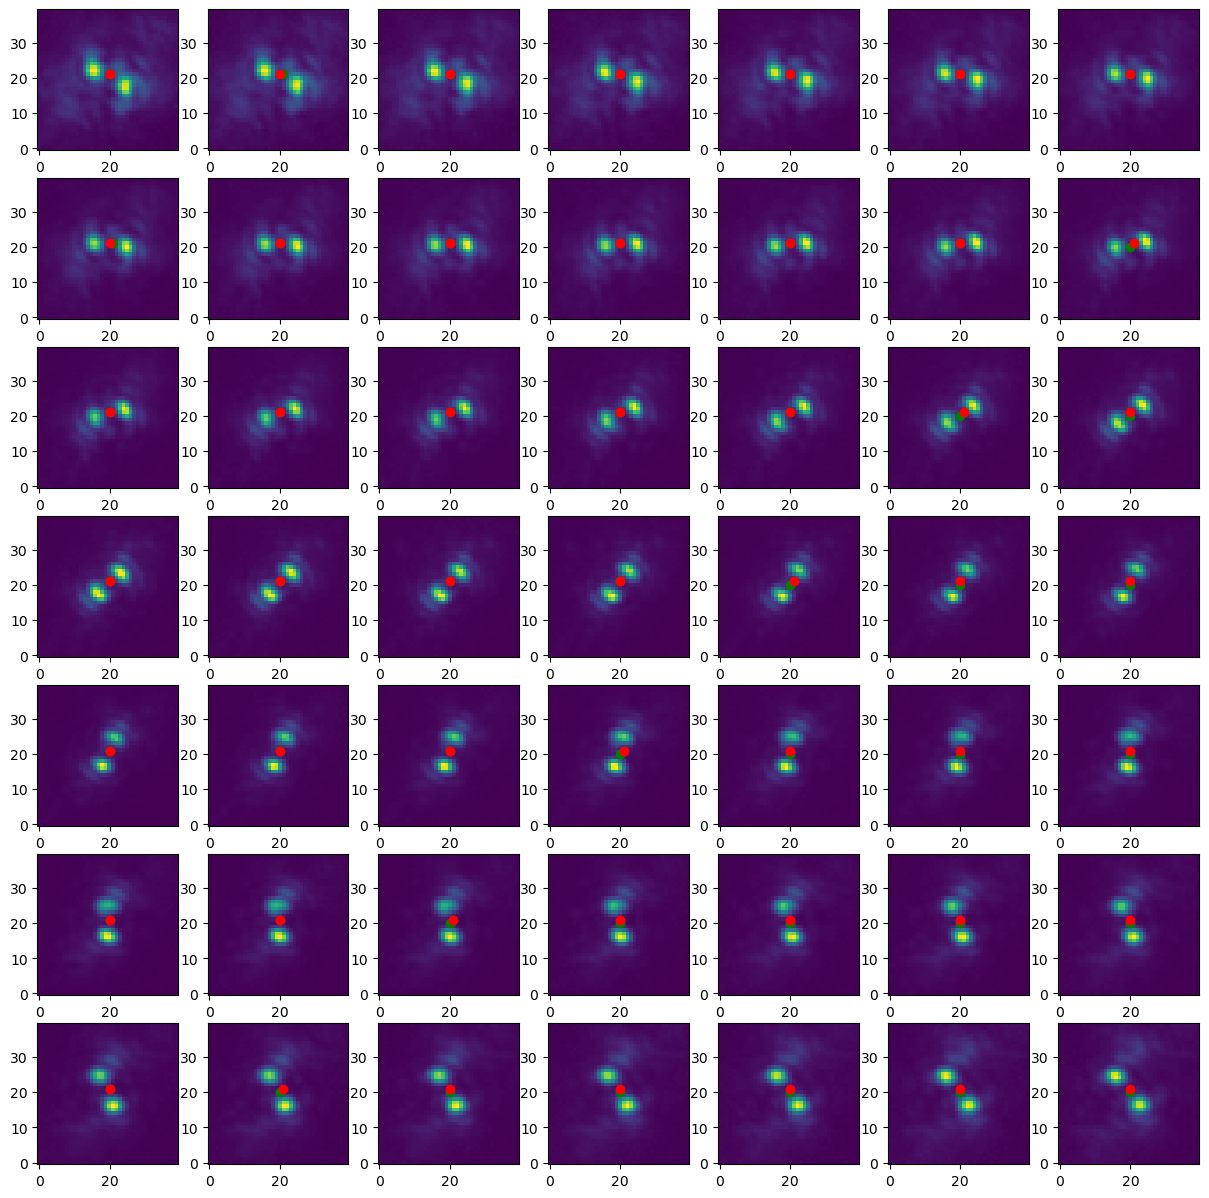

In [14]:
fig, axs = plt.subplots(7, 7, figsize=(15, 15))
count = 0
for i in list(range(7)):
    for j in list(range(7)):
        axs[i, j].imshow(dh_stack[:,:,count], origin="lower")
        axs[i, j].scatter(maxXforOptSigma[i+j], maxYforOptSigma[i+j], color="green")
        axs[i, j].scatter(maxX[i+j], maxY[i+j], color="red")
        count = count + 1


In [27]:
sigs

array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,
        4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,
        5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,
        6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,
        7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,
        8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,
        9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8,
       10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9,
       12. , 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. ,
       13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1,
       14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2,
       15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16